In [9]:
import scanpy as sc
from pathlib import Path
import scvi
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [2]:
DATA = Path("../data")
MODEL = Path("../model")

#### Load samples into Anndata

In [3]:
adatas = []
for file in DATA.iterdir():
    if file.is_dir() and file.name != "NK":
        adata = sc.read_10x_mtx(file,prefix=file.name + "_")
        sample = file.name.split("_")
        if sample[-1] == "1" or sample[-1] == "Tcell":
            adata.obs['sample'] = 1
        else:
            adata.obs['sample'] = 2
        if sample[-2] == "DNT":
            if sample[-3] == "Naive":
                adata.obs['cell_type'] = "nDNT"
            else:
                adata.obs['cell_type'] = "aDNT"
        else:
            adata.obs['cell_type'] = sample[-2]
        adatas.append(adata)
    if file.is_dir() and file.name == "NK":
        for csv in file.iterdir():
            adata = sc.read_csv(csv)
            adata = adata.T
            adata.obs['sample'] = 1
            adata.obs['cell_type'] = "NK"
            adatas.append(adata)

adata = sc.concat(adatas)
adata.obs_names_make_unique()
adata.var_names_make_unique()

c:\Users\xuqin\miniconda3\envs\scvi-env\lib\site-packages\anndata\_core\anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
sc.pp.filter_cells(adata,min_genes=200)
sc.pp.filter_genes(adata,min_cells=3)

In [46]:
adata.var['mt'] = adata.var.index.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata,qc_vars=['mt'],percent_top=None,log1p=False,inplace=True)
adata = adata[adata.obs['pct_counts_mt'] < 15]

In [63]:
adata.write_h5ad(DATA / "threshold.h5ad")

#### Reload

In [5]:
adata = sc.read_h5ad(DATA / 'threshold.h5ad')
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e10)
sc.pp.log1p(adata)
adata.raw = adata

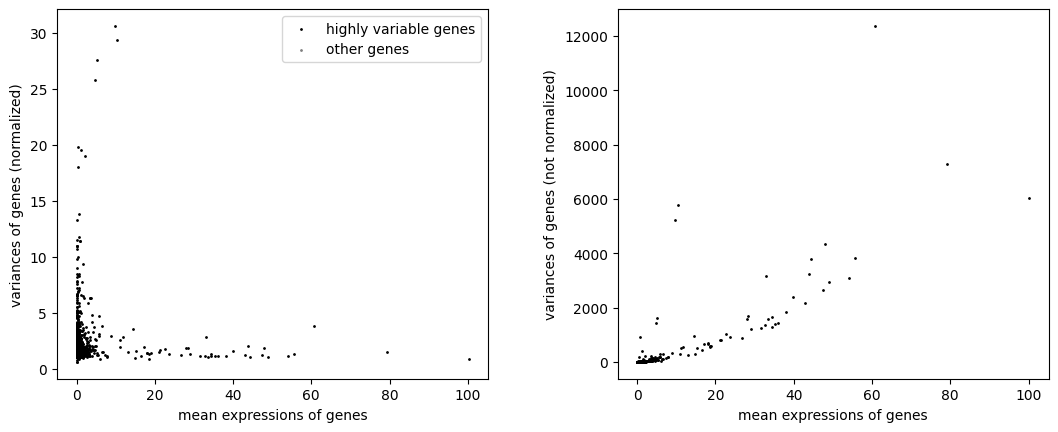

In [6]:
sc.pp.highly_variable_genes(
    adata, 
    n_top_genes=2000,
    batch_key='batch',
    subset=True,
    layer="counts",
    flavor="seurat_v3")

sc.pl.highly_variable_genes(adata)

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer='counts',
    batch_key='batch')

vae_solo = scvi.model.SCVI(adata)
vae_solo.train(max_epochs=100)

In [ ]:
scvi.model.SCVI.save(
    vae_solo,
    'trained_solo.model',
    overwrite=True,
    save_anndata=True)

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(vae_solo)
solo.train()

In [ ]:
df = solo.predict()
df['prediction'] = solo.predict(soft=False)
singlets = df[df['prediction'] == 'singlet']
adata.obs['singlet'] = adata.obs_names.isin(singlets.index)
adata.write_h5ad(DATA / "doublet.h5ad")

#### Reload

In [10]:
adata = sc.read_h5ad(DATA / "doublet.h5ad")

In [11]:
grouped = adata.obs.groupby(["cell_type","singlet"]).agg({'singlet':'count'})
g = grouped.reset_index(allow_duplicates=True)
g.columns = ['cell_type','is_singlet','cell_number']
g['is_singlet'] = g['is_singlet'].map(lambda x: "singlet" if x else "doublet")

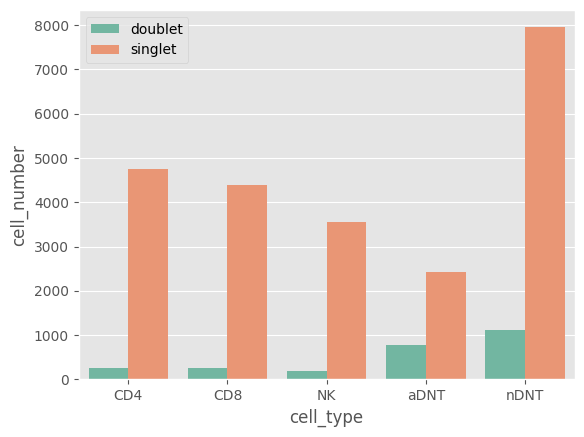

In [12]:
sns.set_palette("Set2")
sns.barplot(g, x='cell_type', y='cell_number',hue='is_singlet')
plt.gca().legend().set_title("")

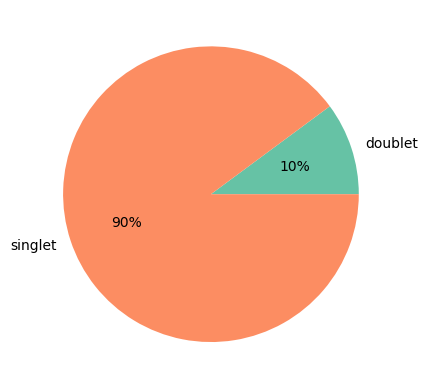

In [14]:
g1 = g.groupby('is_singlet').agg({'cell_number':'sum'})
g1 = g1.reset_index()
plt.pie(g1['cell_number'],labels=['doublet','singlet'],autopct="%.00f%%")
plt.show()